# Import libraries

In [490]:

import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo 


# Import and Save Raw data

* Import raw_data from UCIREPO

In [491]:
def import_rawdata():
    # fetch dataset 
    regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 

    # create dataframes (features, targets, variables, raw_df)

    features = regensburg_pediatric_appendicitis.data.features 
    targets = regensburg_pediatric_appendicitis.data.targets 
    raw_df = pd.concat([features,targets], axis = 1)
    variables = regensburg_pediatric_appendicitis.variables

    print("Data imported succesfully")
    return {
         'raw_data':raw_df 
        ,'features': features
        ,'targets': targets
        ,'variables': variables
    }   

* Export raw data for data versioning

In [492]:
def save_rawdata(imported_data):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    path = os.path.join(parent_directory,'data/raw/uci_df_raw.csv')
    imported_data.to_csv(path)

    print("Data stored at:", path)
    return None

# Data cleansing

* Get list of features for each feature type: Continuous, Categorical, Integer, Binary

In [493]:
def get_features(features_df, feature_type):
    df_featuretype = features_df[(features_df['type'] == feature_type) & (features_df['role'] == 'Feature')]
    features = df_featuretype['name'].unique()
    features = list(features)    

    print(feature_type,"features list created succesfully")
    return features

* Create funcions to impute variables, eiether through mean or mode

In [494]:
def continuous_imputation(dataframe,featuretype):
    for feature in featuretype:
        # calculate mean value for the featue within the featureype
        mean_value = dataframe[feature].mean()    
        # Fill NaN values with the median of the column
        dataframe.loc[:, feature] = dataframe[feature].fillna(mean_value)
        # print("Mean imputation for {} executed succesfully".format(feature))
    return None

In [495]:
def integer_imputation(dataframe,featuretype): 
    for feature in featuretype:
        # calculate mean value for the featue within the featureype
        mode_value = dataframe[feature].mode()[0]    
        # Fill NaN values with the median of the column
        dataframe.loc[:, feature] = dataframe[feature].fillna(mode_value)
        #print("Mode imputation for {} executed succesfully".format(feature))       
    return None

In [496]:
def categorical_imputation(dataframe,featuretype):
    for feature in featuretype:
        dataframe.loc[:, feature] = dataframe[feature].fillna('Not present') 
    return None

In [497]:
def binary_imputation(dataframe,featuretype):
    for feature in featuretype:
        dataframe.loc[:, feature] = dataframe[feature].fillna('Unkown') 
    return None

* Create funtion to impute y variable

In [498]:
def impute_y(dataframe):
    # select target feature
    dataframe = dataframe['Diagnosis']
    dataframe = pd.DataFrame(dataframe)
    
    # covert strinf descrriptions to integer featutres
    dataframe.loc[dataframe['Diagnosis']=='appendicitis'] = 1
    dataframe.loc[dataframe['Diagnosis']=='no appendicitis'] = 0

    # impute target feature
    mode_value = dataframe['Diagnosis'].mode()[0]
    dataframe =  dataframe.fillna(mode_value)   
    return dataframe

* Create funcion to verify there are no null values within x,y

In [499]:
def assert_notnulls(dataframe_x, dataframe_y):
    print('Checking null values within dataframe...')
    data_nulls_x = dataframe_x.isnull().sum().sum()
    data_nulls_y = dataframe_y.isnull().sum().sum()   
    assert data_nulls_x == 0
    assert data_nulls_y == 0
    print('Not nulls test passed')
    return None


# Data normalization, encoding and pca

In [500]:
def run_eda(dataframe, features):
    print('')
    print(dataframe[features[:5]].describe())
    plt.figure(figsize=(10, 6))
    sns.pairplot(dataframe[features[:5]], height= 2)


In [501]:
def normalize(dataframe, features):
    scaler = MinMaxScaler()
    continuous_df_features = pd.DataFrame(scaler.fit_transform(dataframe[features]), columns = dataframe[features].columns)
    return continuous_df_features

In [502]:
def encode(dataframe, categorical_features, binary_features):
    categorical_df_features = pd.concat([dataframe[categorical_features],dataframe[binary_features]], axis = 1)
    categorical_df_features = pd.get_dummies(categorical_df_features, drop_first = True)
    return categorical_df_features

In [503]:
def run_pca(dataframe):
    pca = PCA(n_components = 3)
    pca_result = pca.fit_transform(dataframe)

    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    # Explained variance ratio (how much variance each principal component explains)
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Explained variance ratio for each component
    explained_variance = pca.explained_variance_ratio_

    # Create the loadings matrix
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Convert to a DataFrame for better readability
    loadings_df = pd.DataFrame(loadings, index=dataframe.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
    loadings_df

    plt.figure(figsize=(10, 6))
    sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, center=0)
    plt.title('PCA Loadings Matrix')
    plt.xlabel('Principal Components')
    plt.ylabel('Features')
    plt.show()

    selected_features = ['Age','BMI','Height','WBC_Count']
    print(selected_features, ' were selected for dimensionality reduction')
    dataframe = dataframe[selected_features]
    return dataframe

# Preproccesed data integration and save it

In [504]:
def integrate_features_data(X_dataframe,y_dataframe,continuous_df_features,categorical_df_features,integer_features):

    # Integración de variables continuas y categóricas
    X_preprocessed = pd.concat([continuous_df_features,categorical_df_features], axis = 1)

    # Integración de variables integer
    X_preprocessed = pd.concat([X_preprocessed,X_dataframe[integer_features]], axis = 1)

    # Dataframe resultante listo para entrengar el modelo
    data_preprocessed_df = pd.concat([X_preprocessed,y_dataframe], axis = 1)

    return data_preprocessed_df 

* Save preprocessed data

In [505]:
def save_preproccesed_data(dataframe):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    path = os.path.join(parent_directory,'data/processed/uci_df.csv')
    dataframe.to_csv(path)
    print("Data stored at:", path)

# Pipeline y ejecución

Data imported succesfully
Data stored at: /Users/joseovalle/Desktop/mlops_jovalle/mlops_tec/mlops_tarea1/data/raw/uci_df_raw.csv

Continuous features list created succesfully
Categorical features list created succesfully
Binary features list created succesfully
Integer features list created succesfully

Running imputation for continuous features
Running imputation for categorical features
Running imputation for binary features
Running imputation for integer features
Running imputation for target feature

Checking null values within dataframe...
Not nulls test passed
Normalizing contiunous features
encoding categorical features

running EDA

              Age         BMI     Height  Body_Temperature   WBC_Count
count  782.000000  782.000000  782.00000        782.000000  782.000000
mean    11.346451   18.907012  148.01746         37.404516   12.670683
std      3.527649    4.308862   19.40079          0.899619    5.345871
min      0.000000    7.830000   53.00000         26.900000    2.600

<Figure size 1000x600 with 0 Axes>

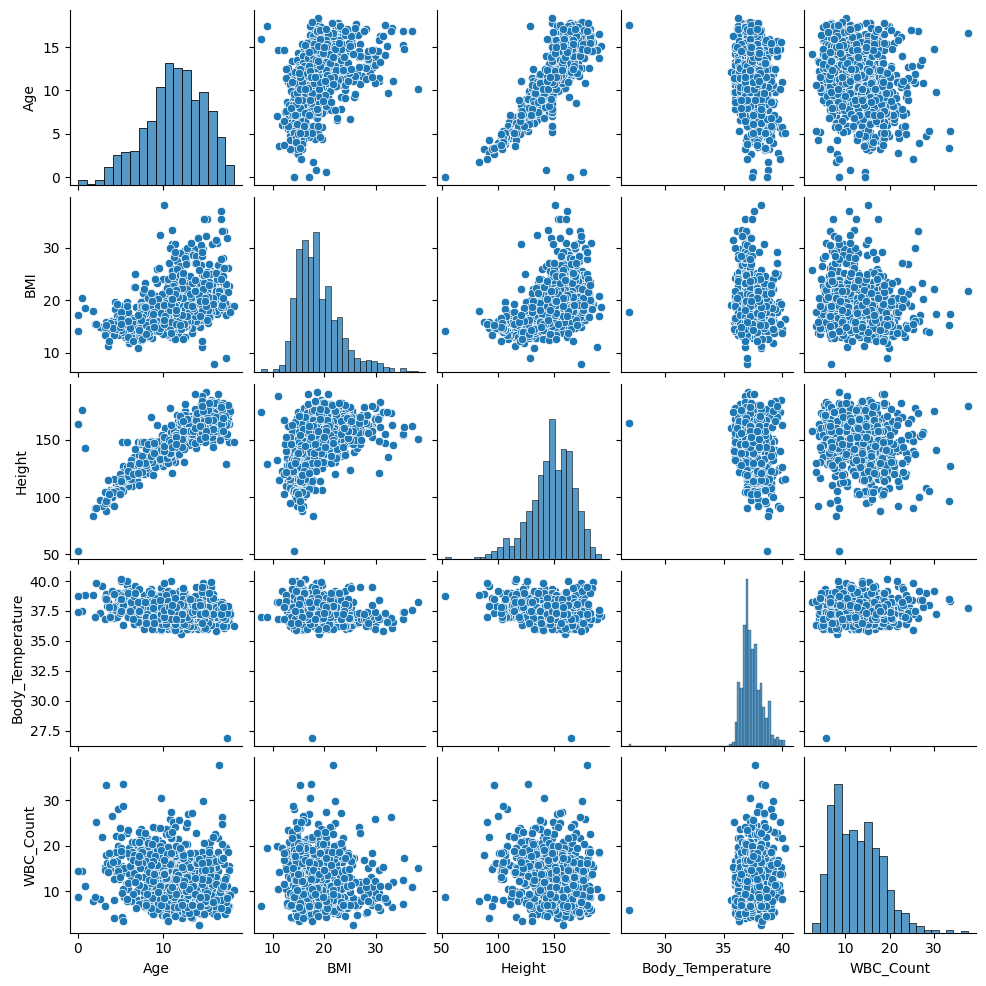

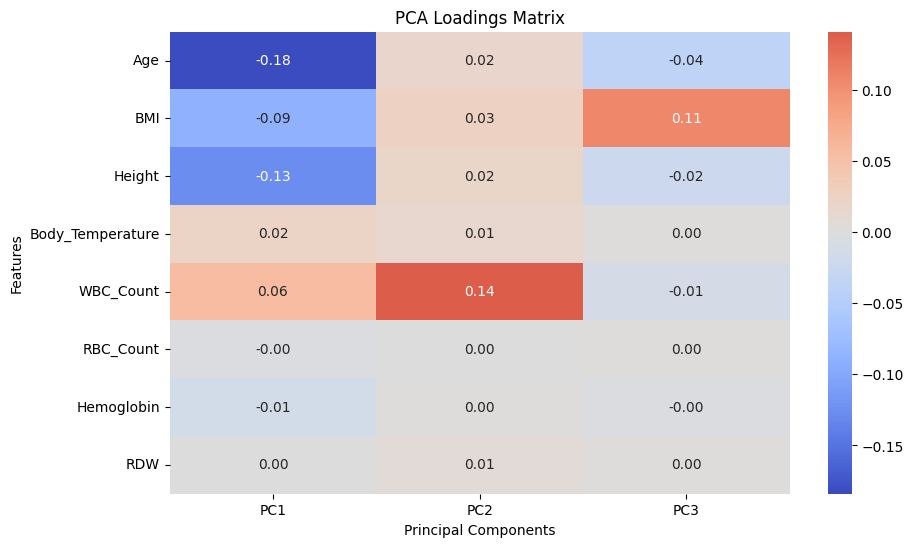

['Age', 'BMI', 'Height', 'WBC_Count']  were selected for dimensionality reduction
Integrating preprocessed ouptut
Data stored at: /Users/joseovalle/Desktop/mlops_jovalle/mlops_tec/mlops_tarea1/data/processed/uci_df.csv


In [506]:
# Pipeline

# Importar raw_ data
import_raw_data = import_rawdata()

# create dataframes for features, targets and variables from impoterted data
X = import_raw_data['features']
y = import_raw_data['targets']
features = import_raw_data['variables']

# Save raw_data
save_raw_data = save_rawdata(import_raw_data['raw_data'])

# Get list of features and their types
print("")
continuous_features = get_features(features,'Continuous')
categorical_features = get_features(features,'Categorical')
binary_features = get_features(features,'Binary')
integer_features = get_features(features,'Integer')

# Value imputation for continous and integer variables
print("")
print("Running imputation for continuous features")
continuous_imputation(X,continuous_features)
print("Running imputation for categorical features")
categorical_imputation(X,categorical_features)
print("Running imputation for binary features")
binary_imputation(X,binary_features)
print("Running imputation for integer features")
integer_imputation(X,integer_features)

# Value imputation for y feature
print("Running imputation for target feature")
y = impute_y(y)

# Validate nulls within X and y
print("")
assert_notnulls(X,y)

# define preproccesed dar
X_preprocessed = X
y_preprocessed = y

# Data normalization
print('Normalizing contiunous features')
continuous_df_features = normalize(X_preprocessed, continuous_features)
#  Encodd categorical features

print('encoding categorical features')
categorical_df_features = encode(X_preprocessed, categorical_features,binary_features)


# run EDA
print("")
print('running EDA')
run_eda(X_preprocessed,continuous_features)

print('running PCA')
# run PCA
continuous_df_features = run_pca(continuous_df_features)

print('Integrating preprocessed ouptut')
preprocessed_data = integrate_features_data(X_preprocessed, y_preprocessed, continuous_df_features,categorical_df_features,integer_features)

save_preproccesed_data(preprocessed_data)





In [507]:
preprocessed_data.head()

,Age,BMI,Height,WBC_Count,Sex_female,Sex_male,Neutrophilia_no,Neutrophilia_yes,Ketones_in_Urine_++,Ketones_in_Urine_+++,...,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_Diameter,Neutrophil_Percentage,Segmented_Neutrophils,Thrombocyte_Count,CRP,Diagnosis
0,0.690632,0.299044,0.683453,0.145299,True,False,True,False,True,False,...,37.0,3.0,4.0,3.0,7.1,68.2,54.0,254.0,0.0,1
1,0.767974,0.793604,0.676259,0.156695,False,True,True,False,False,False,...,69.5,2.0,5.0,4.0,8.0,64.8,54.0,151.0,3.0,0
2,0.770153,0.510056,0.791367,0.301994,True,False,True,False,False,False,...,62.0,4.0,5.0,3.0,8.0,74.8,54.0,300.0,3.0,0
3,0.891612,0.421035,0.805755,0.250712,True,False,True,False,False,False,...,56.0,3.0,7.0,6.0,8.0,63.0,54.0,258.0,0.0,0
4,0.603486,0.299044,0.791367,0.156695,True,False,True,False,False,False,...,45.0,3.0,5.0,6.0,7.0,44.0,54.0,311.0,0.0,1


# Versionado de datos

* Se utilizan herramientas de versionado de datos para mantener un registro de cambios y versiones de los conjuntos de datos utilizados.

* **Los archivos son versionados mediante DVC y se ubican en las carpetas raw y preprocessed**

* **Se genera un almacenamiento remoto local en /data/dvc_storage/**

# ----------------------------------------------------------------------------------------

# Construcción, ajuste y evaluación de modelos de machine learning



* Split entrenamiento y prueba

In [508]:

X_df = uci_df[X_preprocessed.columns]
y_df = uci_df[y_preprocessed.columns].astype(int)


X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, train_size = .8, test_size=0.2, random_state=42, stratify=y_df)

NameError: name 'uci_df' is not defined

* Se genera entrenamiento de modelo con los datos preprocesados


In [ ]:
# Initialize the Random Forest Classifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, np.array(y_train).flatten())
y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Print accuracy and confusion matrix
print("Accuracy of the model:", round(accuracy,4))
print("")

Accuracy of the model: 0.9427



* Evaluar los modelos utilizando métricas de rendimiento específicas.

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        64
           1       0.92      0.99      0.95        93

    accuracy                           0.94       157
   macro avg       0.95      0.93      0.94       157
weighted avg       0.95      0.94      0.94       157



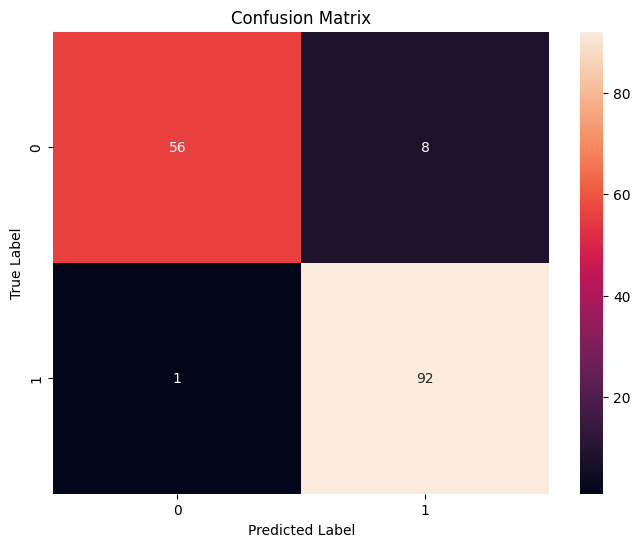

In [ ]:

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot = True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

* Se reealiza ajustes de hiperparámetros para optimizar el rendimiento del modelo.

In [ ]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5,8],
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, np.array(y_train).flatten())

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


* Entrenamiento con mejora de hiper parámetros

Accuracy of the model: 0.9172

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        64
           1       0.91      0.96      0.93        93

    accuracy                           0.92       157
   macro avg       0.92      0.91      0.91       157
weighted avg       0.92      0.92      0.92       157



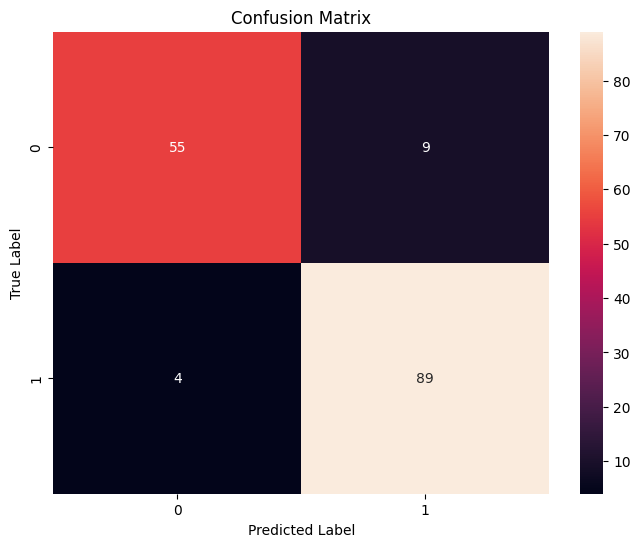

In [ ]:
rf_classifier_hp = RandomForestClassifier(n_estimators = grid_search.best_params_['n_estimators']
                                          ,random_state=42
                                          ,max_depth = grid_search.best_params_['max_depth'] 
                                          ,min_samples_split = grid_search.best_params_['min_samples_split']                                           
                                          )
rf_classifier_hp.fit(X_train, np.array(y_train).flatten())
y_pred_hp = rf_classifier_hp.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_hp)
confusion = confusion_matrix(y_test, y_pred_hp)

# Print accuracy and confusion matrix
print("Accuracy of the model:", round(accuracy,4))
print("")

print("Classification Report:")
print(classification_report(y_test, y_pred_hp))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot = True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Aplicación de mejores prácticas en el pipeline de modelado
* Implementar pipelines de Machine Learning en donde se automaticen las tareas de preprocesamiento, entrenamiento y evaluación.
* Documentar cada paso del pipeline para asegurar claridad y reproducibilidad.


# Estructuración y refactorización del código
* Organizar el código en módulos y funciones bien definidas.
* Aplicar principios de programación orientada a objetos para mejorar la estructura del código.
* Refactorizar el código existente para mejorar su eficiencia y mantenibilidad.

# Presentación ejectuvia de pase pdf